In [1]:
import fastbook
fastbook.setup_book()
import torch
from fastbook import *
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
path = Path('/home/pmshiva/bi-imaging-data/hrd/ova/bloom/data/imgs/train_patches_bloom/')
path.ls()

(#2) [Path('/home/pmshiva/bi-imaging-data/hrd/ova/bloom/data/imgs/train_patches_bloom/hrd'),Path('/home/pmshiva/bi-imaging-data/hrd/ova/bloom/data/imgs/train_patches_bloom/hrp')]

In [3]:
data = ImageDataLoaders.from_folder(path,valid_pct = 0.1, bs = 512, num_workers = 20)

In [4]:
learn = vision_learner(data, models.resnet50, metrics = accuracy)
learn.model = torch.nn.DataParallel(learn.model)

In [5]:
learn.fine_tune(2)

AUC-ROC is 0.999834213668495


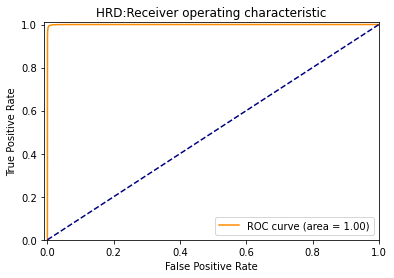

In [6]:
preds,y, loss = learn.get_preds(with_loss=True)
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print(f'AUC-ROC is {roc_auc}')
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('HRD:Receiver operating characteristic')
# plt.savefig('/mnt/disks/external-tcga-data/results/HRD-ROC.png')
plt.legend(loc="lower right")


In [7]:
# compute the confusion matrix
p = np.round(preds.numpy(),0)
tmb_lst = []
ntmb_lst = []
for i in range(len(p)):    
    tmb_lst.append(bool(p[i][0]))
    ntmb_lst.append(bool(p[i][1]))

y_true = y.numpy()
tp = fp = tn = fn = 0
for i in range(len(tmb_lst)):
    if tmb_lst[i] and y_true[i] == 0:
        tp+=1
    elif ~tmb_lst[i] and y_true[i] == 0:
        fp+=1
    elif ntmb_lst[i] and y_true[i] == 1:
        tn+=1
    elif ~ntmb_lst[i] and y_true[i] == 1:
        fn+=1

# remove the comments to print on the screen
print('Validation metrics')
print(f'TN: {tn}')
print(f'FP: {fp}')
print(f'FN: {fn}')
print(f'TP: {tp}')
print(f'sensitivity: {(tp/(tp + fn)):0.4f}')
print(f'specificity: {(tn/(fp + tn)):0.4f}')
print(f'PPV: {(tp/(tp + fp)):0.4f}')
print(f'NPV: {(tn/(tn + fn)):0.4f}')
print(f'F1-score: {((2*tp)/(2*tp + fp + fn)):0.4f}')

Validation metrics
TN: 104508
FP: 560
FN: 535
TP: 89867
sensitivity: 0.9941
specificity: 0.9947
PPV: 0.9938
NPV: 0.9949
F1-score: 0.9939


In [8]:
rec = [str(tp),str(tn),str(fp),str(fn),str(round(tp/(tp + fn),2)),
         str(round(tn/(fp + tn),2)),str(round(tp/(tp + fp),2)),str(round(tn/(tn + fn),2)),
         str(round((2*tp)/(2*tp + fp + fn),2))]
Opath = '/home/pmshiva/bi-imaging-data/hrd/ova/bloom/results/'
csvfile = open(Opath + 'classsification_report_hrd.csv', 'x')
fields = ['Mode','True Positive', 'True Negative', 'False Positive', 'False Negative','sensitivity','specificity'
           ,'PPV', 'NPV','F1-score'] 
csvwriter = csv.writer(csvfile)
csvwriter.writerow(fields)
csvwriter.writerow(rec)
csvfile.close()
learn.model = learn.model.module
learn.export(fname = '/home/pmshiva/bi-imaging-data/hrd/ova/bloom/model/hrd_bloom.pkl')